In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *

from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

### The initial state is prepared as 0,1,3,4,5,7

In [64]:
def A(n):
    qc = QuantumCircuit(n)
    qc.ry(54.735610,0)
    qc.ch(0,1)
    qc.h(2)

    #qc.h(list(range(n)))
    
    AA = qc.to_gate()
    AA.name= 'A'
    
    return AA
    
    #return qc
    

In [65]:
def Ad(n):
    
    qc = A(n)
    qc_g = qc.to_gate(label = 'Adag')
    AAd = qc_g.inverse()
    AAd.name = '$A^{\\dag}$'
    
    return AAd

### Case 1:

- Since there's only 1 bus qubit in the present QRAM, so we can only store a single bit inside each memory cell

- So, in this case we just consider the single bit stored inside each memory cell and ignoring the state of the address qubits in final measured state and perform Oracle operations on those bits only

- This oracle marks the even states, according to the above condition

In [102]:
def Oracle2(): #Sol -> even no.s
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_b)
    qc.x(qr_b[0])
    qc.z(qr_b[0])
    qc.x(qr_b[0])
    

    return qc

In [78]:
def S_0():
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_b)
    
    
    ctr = []
    for k in range(a):
        ctr.append(k)
        
#    qc.barrier()
    qc.x(qr_a)
    qc.x(qr_b)
    qc.h(qr_b[0])
    qc.mct(ctr,qr_b[0])
    qc.h(qr_b[0])
    qc.x(qr_a)
    qc.x(qr_b)

#    qc.barrier()
    return qc
    
#     D = qc.to_gate()
#     D.name = 'Diff'

#     return D

In [79]:
def QRAM(no_of_address_qubits):
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = 2**a # no. of memory qubits
    bus = 1+a  # no. of bus qubits 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(1, "bus")
    #cr = ClassicalRegister(bus, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
    ## adjust the address here
    
    #Inputting the initial state Here-
    qc.append(A(a),list(range(a)))
    
    
    ## Stored 1's in the memory cells -
    qc.x(qr_m[0])
    qc.x(qr_m[2])
    qc.x(qr_m[3])
    qc.x(qr_m[4])

    
### here we will start with the branching
    # there is X gate at the second qubit first
    
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    #qc.barrier()
    
    # further branchings 
    if a==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    
    
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM_order(a))

## finally measuring the bus
#     for i in range(0,a):
#         qc.measure(qr_a[i],cr[i])
#     qc.measure(qr_bus, cr[a])
    
    return qc

In [80]:
def QRM(no_of_address_qubits):
    
    qc = QRAM(no_of_address_qubits)
    qram = qc.to_gate()
    qram.name = 'QRAM'
    return qram
    

In [81]:
def QRAMi(no_of_address_qubits):
    qc = QRAM(no_of_address_qubits)
    qci = qc.to_gate()
    qrami = qci.inverse()
    qrami.name = 'QRAMi'
    return qrami

In [82]:
def meas_QRAM_order(no_of_address_qubits):
    
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = 2**a # no. of memory qubits
    bus = 1+a # no. of bus qubits 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(1, "bus")
    #cr = ClassicalRegister(bus, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
     # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job

    for i in range(0, 2**a  ):
        qc.ccx(qr_r[i], qr_m[int(div_decimal[i])], qr_bus)

    
    return qc

In [83]:
## to functions that we will be using for concatination of "0" and "1" in front the numbers and the other one for addition for the conversion of the binary to decimal 
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)

    num1 += num2
  
    return num1

In [103]:
no_of_address_qubits = 3
a = no_of_address_qubits
r = 2**a # no.of routing qubits
m = 2**a # no. of memory qubits
bus = 1+a # no. of bus qubits 
    
qr_a = QuantumRegister(a, "a")
qr_r = QuantumRegister(r, "r")
qr_m  = QuantumRegister(m,  "m")
qr_b = QuantumRegister(1, "bus")
cr = ClassicalRegister(bus, "readout")
    
qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_b, cr)

qc = qc.compose(QRAM(3))
qc.barrier()

reps = 3

for rep in range(reps):
    qc = qc.compose(Oracle2())
    qc.barrier()
    qc = qc.compose(QRAMi(3))
    qc.barrier()
    qc = qc.compose(S_0())
    qc.barrier()
    qc = qc.compose(QRAM(3))
    qc.barrier()

for i in range(0,a):
    qc.measure(qr_a[i],cr[i])
    
qc.measure(qr_b, cr[a])

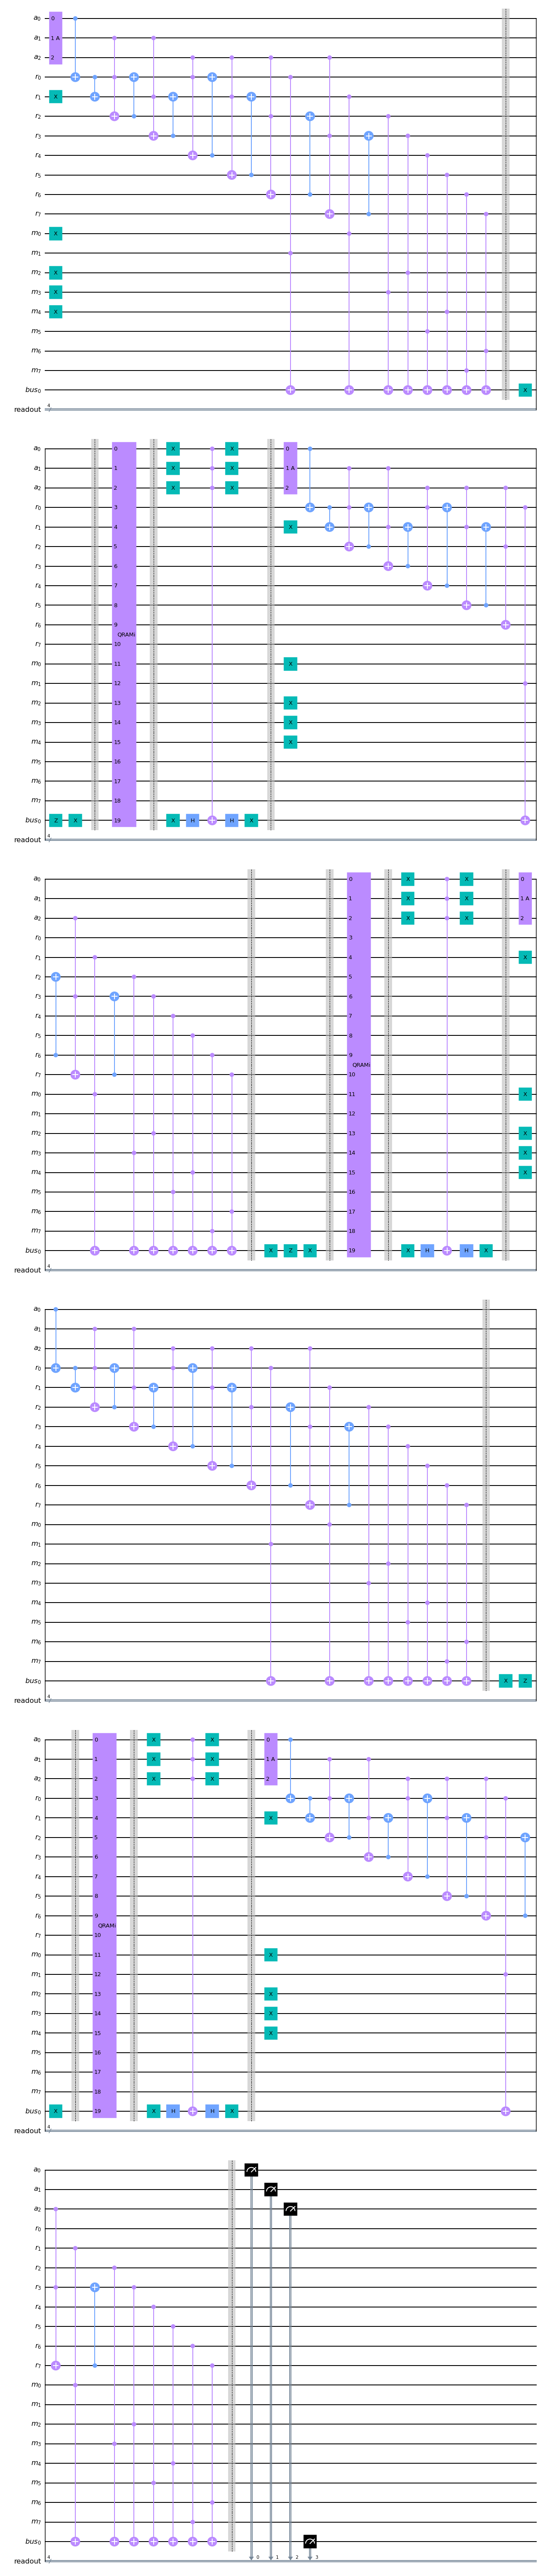

In [104]:
qc.draw('mpl')

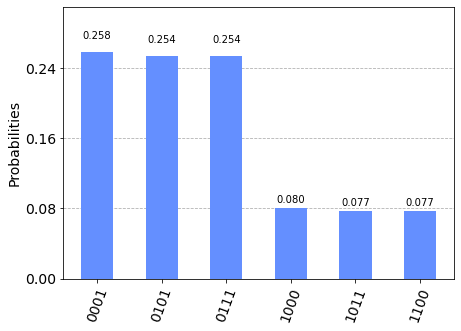

In [105]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)